In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [8]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [9]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [10]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [11]:
# update stride and window size, because data is downsampled
stride = max(int(stride/6), 1)
window_size = max(int(window_size/6), 1)

In [12]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [13]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [14]:
visualize_failure_timeline(filtered_sessions)

In [15]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [16]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6064
Total rows: 837811


### Feature Engineering

In [17]:
downsampled_data['hour_of_day'] = downsampled_data['event_local_time'].dt.hour
downsampled_data['month_of_year'] = downsampled_data['event_local_time'].dt.month
extended_feature_cols += ['hour_of_day', 'month_of_year']


In [18]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [19]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [67]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [65]:
val_df.to_csv("val_processed.csv", index=False)
test_df.to_csv("test_processed.csv", index=False)


In [20]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_of_day',
 'month_of_year']

### Standardization

In [21]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day', 'month_of_year']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [22]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [23]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 23.17it/s]


In [24]:
train_ds.X.shape

torch.Size([257179, 336, 16])

In [25]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    255259
 1.0      1920
 dtype: int64,
 0.0    67168
 1.0      360
 dtype: int64,
 0.0    65157
 1.0      600
 dtype: int64)

In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.25  # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=256,         # 或你的 GPU 極限
    sampler=balanced_sampler,
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # logits: (B,1) raw; targets: (B,1) {0,1}
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
        pt = p*targets + (1-p)*(1-targets)
        w = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = w * (1-pt).pow(self.gamma) * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))


In [35]:
model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=64,   # 32 → 64
    lstm_hidden_size=128,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.3
)

In [36]:
import math
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [47]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=100, 
    num_epochs=5, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=5,
    save_path='model/0814_0147'
)

Model moved to cuda
Resuming training from epoch 11
[Epoch 11/16] Step 0/1004 - Loss: 0.0062
[Epoch 11/16] Step 100/1004 - Loss: 0.0025
[Epoch 11/16] Step 200/1004 - Loss: 0.0011
[Epoch 11/16] Step 300/1004 - Loss: 0.0033
[Epoch 11/16] Step 400/1004 - Loss: 0.0010
[Epoch 11/16] Step 500/1004 - Loss: 0.0004
[Epoch 11/16] Step 600/1004 - Loss: 0.0006
[Epoch 11/16] Step 700/1004 - Loss: 0.0002
[Epoch 11/16] Step 800/1004 - Loss: 0.0003
[Epoch 11/16] Step 900/1004 - Loss: 0.0023
[Epoch 11/16] Step 1000/1004 - Loss: 0.0006
🔁 Epoch 11 finished. Avg Train Loss: 0.0015
✅ Validation Loss: 0.0170 | Acc: 94.86% | AUC-PR: 0.0226 | baseline: 0.0053 | uplift: 4.23x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
[Epoch 12/16] Step 0/1004 - Loss: 0.0063
[Epoch 12/16] Step 100/1004 - Loss: 0.0005
[Epoch 12/16] Step 200/1004 - Loss: 0.0009
[Epoch 12/16] Step 300/1004 - Loss: 0.0005
[Epoch 12/16] Step 400/1004 - Loss: 0.0001
[Epoch 12/16] Step 500/1004 - Loss: 0.0010
[Epoch 1

In [38]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

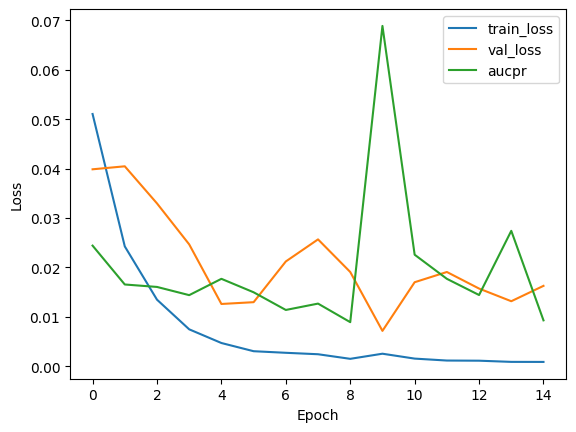

In [48]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [54]:
model.load_state_dict(torch.load(r'model\0814_0147\best_model.pth', weights_only=True))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



<All keys matched successfully>

Performance on Training Set:


Testing: 100%|██████████| 1004/1004 [00:42<00:00, 23.89it/s]


🔍 Test Loss: 0.0021 | Accuracy: 99.42%
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    192731
     Failure       0.98      1.00      0.99     64293

    accuracy                           0.99    257024
   macro avg       0.99      1.00      0.99    257024
weighted avg       0.99      0.99      0.99    257024

[[191230   1501]
 [     0  64293]]
ROC AUC: 0.9992


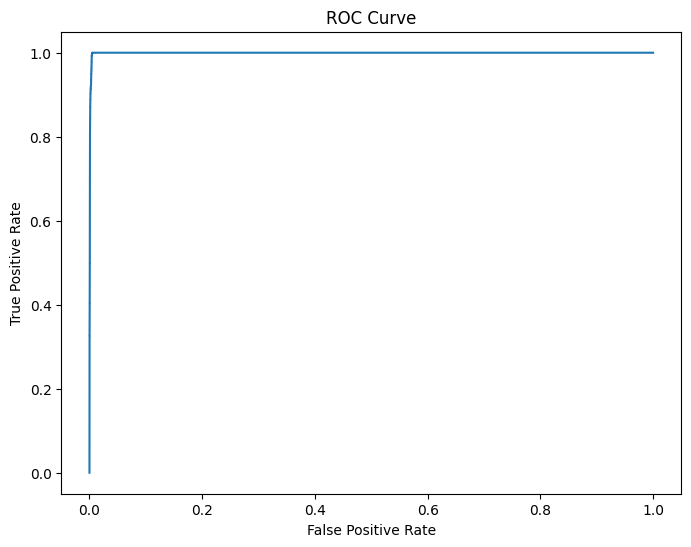

In [55]:
print("Performance on Training Set:")
evaluate_model(model, train_loader, best_threshold=0.5, criterion=criterion)

In [63]:
val_trues, val_predictions, val_outputs = test_loop(model, val_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]

🔍 Test Loss: 0.0071 | Accuracy: 98.16%


(array([2.8349e+04, 1.9463e+04, 8.8430e+03, 3.5980e+03, 1.4750e+03,
        5.6400e+02, 3.3300e+02, 2.7100e+02, 3.3800e+02, 4.2500e+02,
        4.3500e+02, 3.6700e+02, 3.5100e+02, 2.9400e+02, 2.2400e+02,
        1.4600e+02, 1.2000e+02, 9.6000e+01, 9.4000e+01, 1.0800e+02,
        1.1000e+02, 8.8000e+01, 8.2000e+01, 7.5000e+01, 9.8000e+01,
        9.4000e+01, 8.3000e+01, 6.2000e+01, 6.7000e+01, 6.2000e+01,
        5.7000e+01, 6.1000e+01, 4.4000e+01, 3.3000e+01, 5.1000e+01,
        7.0000e+01, 4.8000e+01, 5.2000e+01, 5.9000e+01, 5.0000e+01,
        4.5000e+01, 2.9000e+01, 2.3000e+01, 2.7000e+01, 3.7000e+01,
        3.6000e+01, 1.5000e+01, 2.9000e+01, 2.6000e+01, 2.1000e+01]),
 array([0.01568499, 0.03452905, 0.05337311, 0.07221717, 0.09106123,
        0.1099053 , 0.12874936, 0.14759342, 0.16643748, 0.18528154,
        0.20412561, 0.22296967, 0.24181373, 0.26065779, 0.27950186,
        0.29834592, 0.31718996, 0.33603403, 0.3548781 , 0.37372217,
        0.39256623, 0.41141027, 0.43025434, 0.

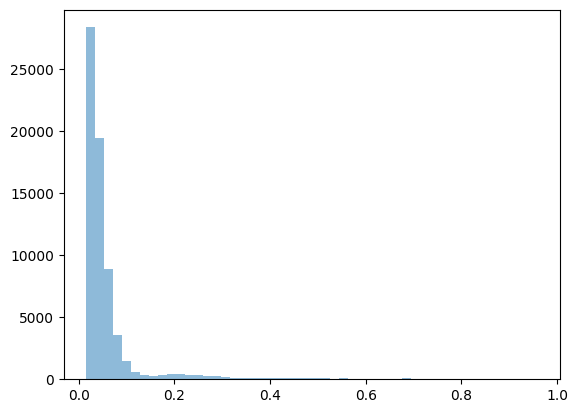

In [70]:
plt.hist(val_outputs, bins=50, alpha=0.5, label='Outputs')

In [ ]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(val_trues, val_outputs, pos_label=1)

target_recall = 0.8
idx = next(i for i,r in enumerate(rec) if r < target_recall) - 1
best_threshold = thresholds[idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={prec[idx]:.3f}")


Threshold for recall ≥ 0.8: 0.0762, Precision=0.029


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.92     67168
     Failure       0.03      0.80      0.06       360

    accuracy                           0.86     67528
   macro avg       0.51      0.83      0.49     67528
weighted avg       0.99      0.86      0.92     67528

[[57666  9502]
 [   72   288]]
ROC AUC: 0.9280


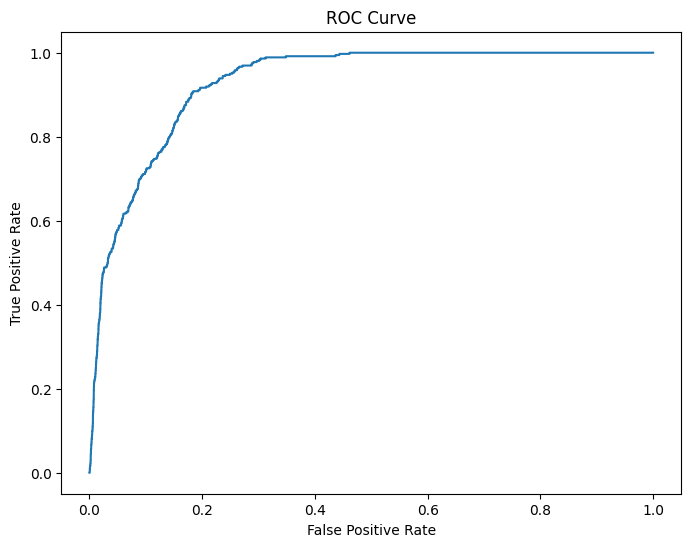

In [ ]:
predictions = (val_outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(val_trues, predictions, val_outputs)

In [60]:
trues, predictions, outputs = test_loop(model, test_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 65/65 [00:26<00:00,  2.44it/s]

🔍 Test Loss: 0.0256 | Accuracy: 98.27%


(array([4.4890e+04, 1.1792e+04, 3.8160e+03, 1.8740e+03, 5.1800e+02,
        3.5400e+02, 2.1500e+02, 2.0200e+02, 1.6100e+02, 1.5300e+02,
        1.4800e+02, 1.3400e+02, 1.1800e+02, 1.2200e+02, 1.1300e+02,
        8.7000e+01, 8.5000e+01, 5.1000e+01, 4.9000e+01, 6.1000e+01,
        6.5000e+01, 6.2000e+01, 5.4000e+01, 4.8000e+01, 4.1000e+01,
        2.1000e+01, 2.5000e+01, 2.6000e+01, 3.0000e+01, 2.4000e+01,
        2.7000e+01, 2.3000e+01, 2.1000e+01, 2.5000e+01, 1.5000e+01,
        2.0000e+01, 1.5000e+01, 2.6000e+01, 2.1000e+01, 1.2000e+01,
        8.0000e+00, 1.6000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
        1.6000e+01, 2.6000e+01, 3.6000e+01, 4.0000e+01, 3.5000e+01]),
 array([0.01399226, 0.0331373 , 0.05228234, 0.07142738, 0.09057242,
        0.10971747, 0.12886252, 0.14800756, 0.1671526 , 0.18629764,
        0.20544267, 0.22458771, 0.24373275, 0.26287779, 0.28202283,
        0.30116788, 0.32031292, 0.33945796, 0.358603  , 0.37774804,
        0.39689308, 0.41603813, 0.43518317, 0.

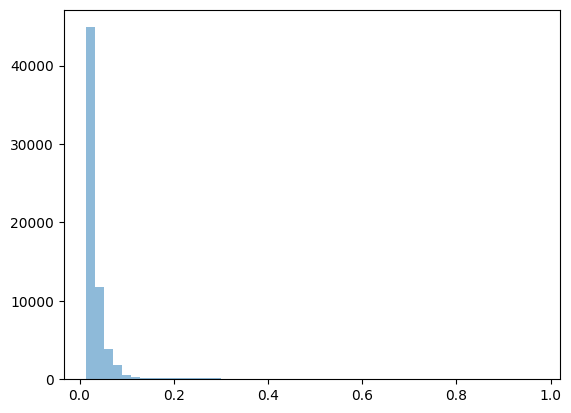

In [62]:
plt.hist(outputs, bins=50, alpha=0.5, label='Outputs')

Performance on Test Set:


Testing: 100%|██████████| 65/65 [00:31<00:00,  2.04it/s]


🔍 Test Loss: 0.0256 | Accuracy: 92.38%
              precision    recall  f1-score   support

      Normal       0.99      0.93      0.96     65157
     Failure       0.01      0.05      0.01       600

    accuracy                           0.92     65757
   macro avg       0.50      0.49      0.49     65757
weighted avg       0.98      0.92      0.95     65757

[[60714  4443]
 [  570    30]]
ROC AUC: 0.5195


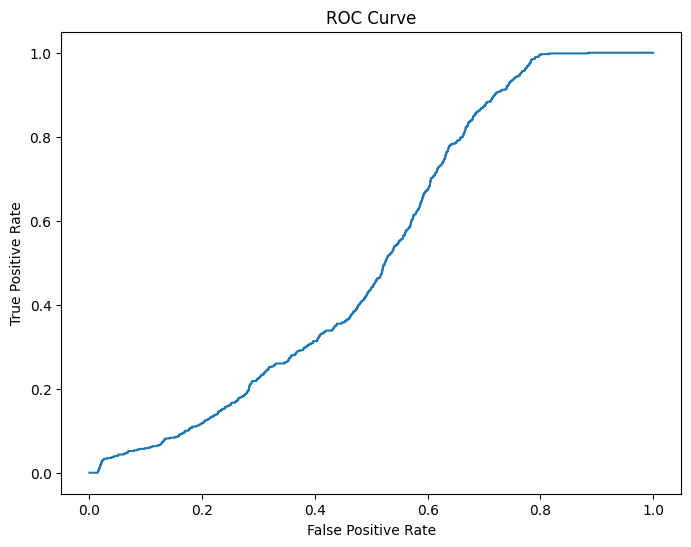

In [59]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)